# Import libraries

In [ ]:
import numpy as np
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download("punkt")
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
import seaborn as sns
import re
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression, PassiveAggressiveClassifier, Perceptron
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
import sklearn.feature_extraction.text as text
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense,Conv1D,Embedding,GlobalAveragePooling1D,LSTM,Bidirectional,Dropout,GlobalMaxPooling1D,SpatialDropout1D,MaxPooling1D,Flatten

# Reading and Viewing Data

In [2]:
data = pd.read_csv("/content/news.csv")
data.head()

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


In [3]:
data.isnull().sum()

Unnamed: 0    0
title         0
text          0
label         0
dtype: int64

In [4]:
print("Number of fake news: ",len(data[data['label']=="FAKE"]))
print("Number of real news: ",len(data[data['label']=="REAL"]))

Number of fake news:  3164
Number of real news:  3171


# **Exploratory Data Analysis**

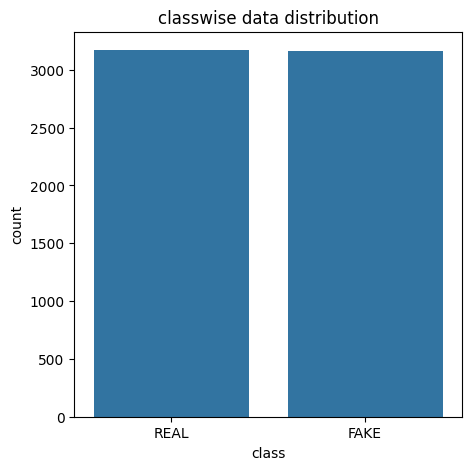

In [5]:
counts = data['label'].value_counts()
plt.figure(figsize=(5,5))
sns.barplot(x=counts.index,y=counts.values)
plt.title("classwise data distribution")
plt.xlabel("class")
plt.ylabel("count")
plt.show()

In [6]:
data["news_size"] = data['text'].apply(len)
data.head()

,Unnamed: 0,title,text,label,news_size
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE,7518
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE,2646
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL,2543
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE,2660
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL,1840


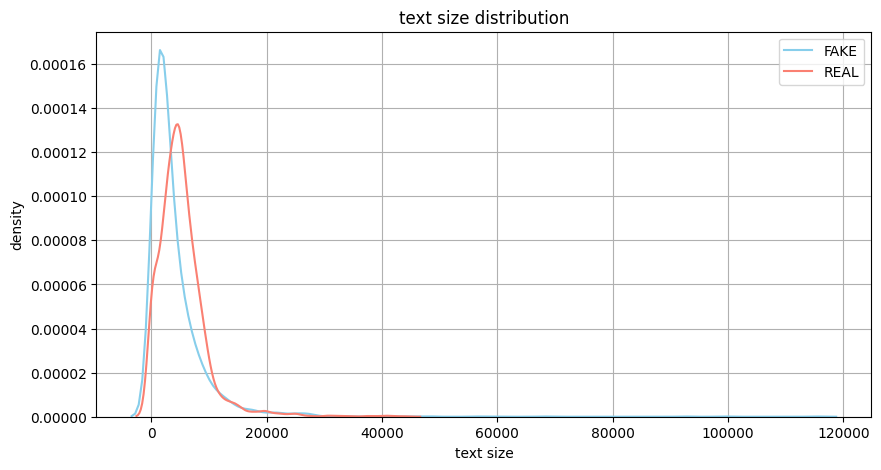

In [7]:
# kernel density estimate (KDE) plot
plt.figure(figsize=(10,5))
sns.kdeplot(data[data['label']=='FAKE']['news_size'],color="skyblue",label="FAKE")
sns.kdeplot(data[data['label']=='REAL']['news_size'],color="salmon",label="REAL")
plt.title("text size distribution")
plt.xlabel("text size")
plt.ylabel("density")
plt.legend()
plt.grid(True)
plt.show()

<Figure size 1000x600 with 0 Axes>

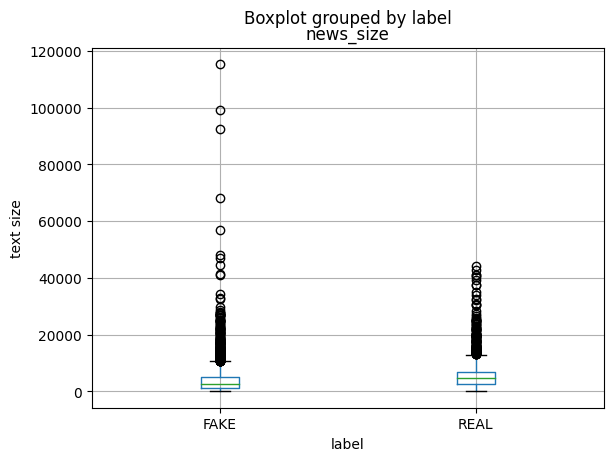

In [8]:
plt.figure(figsize=(10,6))
data.boxplot(column="news_size",by="label",grid=True)
plt.xlabel("label")
plt.ylabel("text size")
plt.show()

In [9]:
max(data['news_size'])

115372

# **Text Preprocessing**

In [10]:
def clean_data(text):
  # convert to lower case
  text = text.lower()
  # remove punctuation, non alphanumeric characters, remove whitspaces
  text = re.sub(r"[^\w\s]","",text)
  # tokanization
  tokens = word_tokenize(text)
  # remove stopwords, lemmitization
  lemmitizer = WordNetLemmatizer()
  stop_words = set(stopwords.words("english"))
  tokens = [lemmitizer.lemmatize(token) for token in tokens if token not in stop_words]

  return tokens

In [11]:
tokens = data['text'].apply(clean_data)
# joining tokens
cleaned_data = [" ".join(token) for token in tokens]
data['text'] = cleaned_data

In [12]:
data.head()

,Unnamed: 0,title,text,label,news_size
0,8476,You Can Smell Hillary’s Fear,daniel greenfield shillman journalism fellow f...,FAKE,7518
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,google pinterest digg linkedin reddit stumbleu...,FAKE,2646
2,3608,Kerry to go to Paris in gesture of sympathy,u secretary state john f kerry said monday sto...,REAL,2543
3,10142,Bernie supporters on Twitter erupt in anger ag...,kaydee king kaydeeking november 9 2016 lesson ...,FAKE,2660
4,875,The Battle of New York: Why This Primary Matters,primary day new york frontrunners hillary clin...,REAL,1840


In [13]:
data["news_size"] = data['text'].apply(len)
data.head()

,Unnamed: 0,title,text,label,news_size
0,8476,You Can Smell Hillary’s Fear,daniel greenfield shillman journalism fellow f...,FAKE,4889
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,google pinterest digg linkedin reddit stumbleu...,FAKE,1773
2,3608,Kerry to go to Paris in gesture of sympathy,u secretary state john f kerry said monday sto...,REAL,1725
3,10142,Bernie supporters on Twitter erupt in anger ag...,kaydee king kaydeeking november 9 2016 lesson ...,FAKE,1968
4,875,The Battle of New York: Why This Primary Matters,primary day new york frontrunners hillary clin...,REAL,1218


In [14]:
encoder = LabelEncoder()
data['label'] = encoder.fit_transform(data['label'])
data.head()

,Unnamed: 0,title,text,label,news_size
0,8476,You Can Smell Hillary’s Fear,daniel greenfield shillman journalism fellow f...,0,4889
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,google pinterest digg linkedin reddit stumbleu...,0,1773
2,3608,Kerry to go to Paris in gesture of sympathy,u secretary state john f kerry said monday sto...,1,1725
3,10142,Bernie supporters on Twitter erupt in anger ag...,kaydee king kaydeeking november 9 2016 lesson ...,0,1968
4,875,The Battle of New York: Why This Primary Matters,primary day new york frontrunners hillary clin...,1,1218


# Split data to train and test

In [15]:
X_train, X_test, Y_train, Y_test = train_test_split(data['text'], data['label'],random_state=45, test_size=0.20)

# **Models**

## 1. Traditional Models

## Feature Extraction using TF-IDF

In [16]:
def feature_extraction(x_train,x_test):
  vectorizer = TfidfVectorizer()
  tfidf_matrix = text.TfidfTransformer(norm="l2")
  train_frequencies = vectorizer.fit_transform(x_train)
  test_frequencies = vectorizer.transform(x_test)
  tfidf_matrix.fit(train_frequencies)
  train_tfidf_matrix = tfidf_matrix.transform(train_frequencies)
  test_tfidf_matrix = tfidf_matrix.transform(test_frequencies)
  return train_tfidf_matrix, test_tfidf_matrix


In [17]:
train_features, test_features = feature_extraction(X_train, X_test)

## Traing and Test Model

In [18]:
def traditional_model(classifier, x_train, y_train, x_test, y_test):
  classifier.fit(x_train, y_train)
  predictions = classifier.score(x_test, y_test)
  print("Accuracy :", predictions * 100)

## Models Accuracy 

In [19]:
print("logistic regression:")
traditional_model(LogisticRegression(), train_features, Y_train, test_features, Y_test)

print("Decision Tree:")
traditional_model(DecisionTreeClassifier(), train_features, Y_train, test_features, Y_test)

print("Gradient Boosting:")
traditional_model(GradientBoostingClassifier(random_state=0), train_features, Y_train, test_features, Y_test)

print("Random Forest:")
traditional_model(RandomForestClassifier(random_state=0), train_features, Y_train, test_features, Y_test)

passive_classifier = PassiveAggressiveClassifier(random_state = 8)
print("Passive Aggressive:")
traditional_model(passive_classifier, train_features, Y_train, test_features, Y_test)

print("AdaBoost:")
traditional_model(AdaBoostClassifier(), train_features, Y_train, test_features, Y_test)

print("Bagging:")
traditional_model(BaggingClassifier(), train_features, Y_train, test_features, Y_test)

print("KNN:")
traditional_model(KNeighborsClassifier(), train_features, Y_train, test_features, Y_test)

print("Multinomial Naive Bayes:")
traditional_model(MultinomialNB(), train_features, Y_train, test_features, Y_test)

print("Perceptron:")
traditional_model(Perceptron(), train_features, Y_train, test_features, Y_test)

print("SVM:")
traditional_model(SVC(), train_features, Y_train, test_features, Y_test)

logistic regression:
Accuracy : 91.63378058405682
Decision Tree:
Accuracy : 81.29439621152328
Gradient Boosting:
Accuracy : 88.7924230465667
Random Forest:
Accuracy : 90.37095501183899
Passive Aggressive:
Accuracy : 94.71191791633781
AdaBoost:
Accuracy : 87.7663772691397
Bagging:
Accuracy : 87.13496448303079
KNN:
Accuracy : 51.77584846093133
Multinomial Naive Bayes:
Accuracy : 84.68823993685872
Perceptron:
Accuracy : 92.97553275453828
SVM:
Accuracy : 92.89660615627466


## Confusion Matrix

In [1]:
def visualize_results(y_true, y_pred):
  # confusion matrix
  cm = confusion_matrix(y_true, y_pred)
  plt.figure(figsize=(7, 4))
  sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")
  plt.xlabel("Predicted")
  plt.ylabel("Actual")
  plt.title("Confusion matrix")
  plt.show()

  # Classification report
  report = classification_report(y_true, y_pred)
  print("Classification report: \n",report)

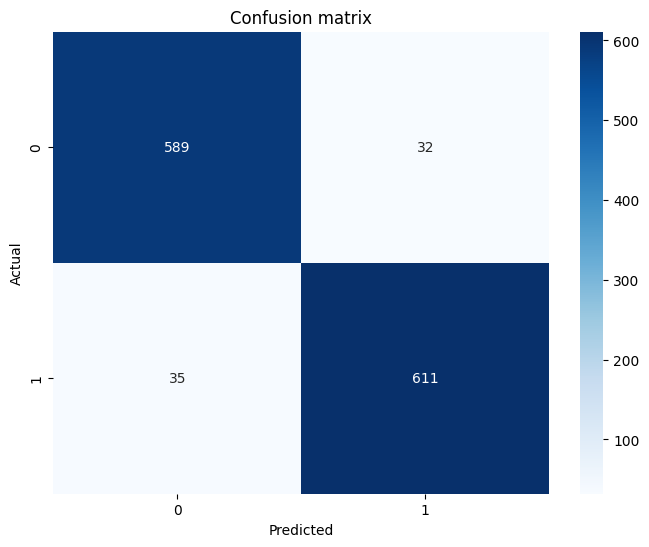

Classification report: 
               precision    recall  f1-score   support

           0       0.94      0.95      0.95       621
           1       0.95      0.95      0.95       646

    accuracy                           0.95      1267
   macro avg       0.95      0.95      0.95      1267
weighted avg       0.95      0.95      0.95      1267



In [22]:
visualize_results(Y_test,passive_classifier.predict(test_features))

## Save Model

In [24]:
import pickle
with open('passive_model.pkl', 'wb') as f:
    pickle.dump(passive_classifier, f)

## 2. Deep Learning Models

## Word2Vec

In [25]:
DIM = 90
w2v_model = Word2Vec(sentences=tokens, vector_size=DIM, window=5, min_count=1)
tokenizer = Tokenizer()
tokenizer.fit_on_texts(tokens)
x = tokenizer.texts_to_sequences(tokens)
vocab_size = len(tokenizer.word_index) + 1

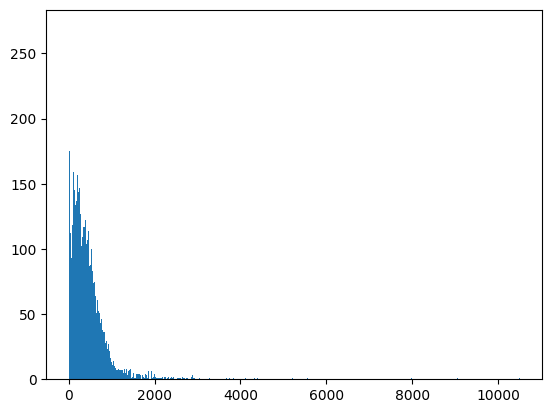

In [26]:
plt.hist([len(value) for value in x],bins=700)
plt.show()

In [27]:
l =[len(value) for value in x]
max(l)

10496

In [28]:
maxlen = 1200
x = pad_sequences(x,padding='pre',maxlen=maxlen)
y = data['label']

In [29]:
def get_weights_matrix(model):
    weight_matrix = np.zeros((vocab_size,DIM))
    vocab = tokenizer.index_word
    for i, word in vocab.items():
        weight_matrix[i] = model.wv[word]
    return weight_matrix

In [30]:
embedding_vectors = get_weights_matrix(w2v_model)

In [31]:
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2,random_state=20)

## **LSTM Model**

In [ ]:
lstm_model = Sequential()
lstm_model.add(Embedding(vocab_size, output_dim=DIM, weights=[embedding_vectors], input_length=maxlen))
lstm_model.add(LSTM(32))
lstm_model.add(Dropout(0.5))
lstm_model.add(Dense(1,activation="sigmoid"))
lstm_model.compile(loss="binary_crossentropy",optimizer="adam",metrics=["accuracy"])
lstm_model.summary()

In [33]:
lstm_model.fit(x_train,y_train,epochs=15,batch_size=32,validation_data=(x_test,y_test))

Epoch 1/15
159/159 [==============================] - 163s 1s/step - loss: 0.5407 - accuracy: 0.7277 - val_loss: 0.4235 - val_accuracy: 0.7987
Epoch 2/15
159/159 [==============================] - 137s 862ms/step - loss: 0.3677 - accuracy: 0.8479 - val_loss: 0.3032 - val_accuracy: 0.8792
Epoch 3/15
159/159 [==============================] - 140s 880ms/step - loss: 0.3192 - accuracy: 0.8796 - val_loss: 0.2806 - val_accuracy: 0.9021
Epoch 4/15
159/159 [==============================] - 127s 802ms/step - loss: 0.2927 - accuracy: 0.8893 - val_loss: 0.2949 - val_accuracy: 0.8777
Epoch 5/15
159/159 [==============================] - 131s 823ms/step - loss: 0.2122 - accuracy: 0.9266 - val_loss: 0.2641 - val_accuracy: 0.9148
Epoch 6/15
159/159 [==============================] - 128s 805ms/step - loss: 0.1621 - accuracy: 0.9449 - val_loss: 0.2189 - val_accuracy: 0.9163
Epoch 7/15
159/159 [==============================] - 132s 833ms/step - loss: 0.1071 - accuracy: 0.9659 - val_loss: 0.2108 - va

In [34]:
lstm_pred = lstm_model.predict(x_test)
lstm_pred = np.round(lstm_pred)
print("LSTM Accuracy: ",accuracy_score(y_test,lstm_pred))

40/40 [==============================] - 7s 166ms/step
LSTM Accuracy:  0.9171270718232044


## **CNN Model**

In [35]:
cnn_model = Sequential()
cnn_model.add(Embedding(vocab_size, output_dim=DIM, weights=[embedding_vectors], input_length=maxlen))
cnn_model.add(Conv1D(32, 3, padding='same', activation='relu'))
cnn_model.add(MaxPooling1D())
cnn_model.add(Flatten())
cnn_model.add(Dense(250, activation='relu'))
cnn_model.add(Dense(1, activation='sigmoid'))
cnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 1200, 90)          7256790   
                                                                 
 conv1d (Conv1D)             (None, 1200, 32)          8672      
                                                                 
 max_pooling1d (MaxPooling1  (None, 600, 32)           0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 19200)             0         
                                                                 
 dense_1 (Dense)             (None, 250)               4800250   
                                                                 
 dense_2 (Dense)             (None, 1)                 251       
                                                      

In [36]:
cnn_model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=4, batch_size=128, verbose=2)

Epoch 1/4
40/40 - 33s - loss: 1.4800 - accuracy: 0.5341 - val_loss: 0.6400 - val_accuracy: 0.5328 - 33s/epoch - 813ms/step
Epoch 2/4
40/40 - 31s - loss: 0.5502 - accuracy: 0.6762 - val_loss: 0.3783 - val_accuracy: 0.8350 - 31s/epoch - 787ms/step
Epoch 3/4
40/40 - 32s - loss: 0.2940 - accuracy: 0.8838 - val_loss: 0.3110 - val_accuracy: 0.8792 - 32s/epoch - 811ms/step
Epoch 4/4
40/40 - 30s - loss: 0.1995 - accuracy: 0.9288 - val_loss: 0.2482 - val_accuracy: 0.9116 - 30s/epoch - 749ms/step


In [37]:
cnn_pred = cnn_model.predict(x_test)
cnn_pred = np.round(cnn_pred)
print("CNN Accuracy: ",accuracy_score(y_test,cnn_pred))

40/40 [==============================] - 1s 35ms/step
CNN Accuracy:  0.9116022099447514


## AlexNet Model

In [38]:
alexnet_model = Sequential()
alexnet_model.add(Embedding(vocab_size, output_dim=DIM, weights=[embedding_vectors], input_length=maxlen))
alexnet_model.add(Conv1D(32, 11, strides= 4, activation='relu'))
alexnet_model.add(MaxPooling1D(pool_size=3, strides=2))
alexnet_model.add(Conv1D(64, 5, padding='same', activation='relu'))
alexnet_model.add(MaxPooling1D(pool_size=3, strides=2))
alexnet_model.add(Conv1D(128, 3, padding='same', activation='relu'))
alexnet_model.add(Conv1D(128, 3, padding='same', activation='relu'))
alexnet_model.add(Conv1D(64, 3, padding='same', activation='relu'))
alexnet_model.add(MaxPooling1D(pool_size=3, strides=2))
alexnet_model.add(Flatten())
alexnet_model.add(Dense(512, activation='relu'))
alexnet_model.add(Dropout(0.2))
alexnet_model.add(Dense(256, activation='relu'))
alexnet_model.add(Dropout(0.5))
alexnet_model.add(Dense(1, activation='sigmoid'))
alexnet_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
alexnet_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 1200, 90)          7256790   
                                                                 
 conv1d_1 (Conv1D)           (None, 298, 32)           31712     
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 148, 32)           0         
 g1D)                                                            
                                                                 
 conv1d_2 (Conv1D)           (None, 148, 64)           10304     
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 73, 64)            0         
 g1D)                                                            
                                                                 
 conv1d_3 (Conv1D)           (None, 73, 128)          

In [43]:
alexnet_model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=10, batch_size=32)

Epoch 1/10
159/159 [==============================] - 58s 360ms/step - loss: 0.0159 - accuracy: 0.9957 - val_loss: 0.3956 - val_accuracy: 0.9329
Epoch 2/10
159/159 [==============================] - 48s 302ms/step - loss: 0.0178 - accuracy: 0.9953 - val_loss: 0.4597 - val_accuracy: 0.9408
Epoch 3/10
159/159 [==============================] - 48s 303ms/step - loss: 0.0034 - accuracy: 0.9994 - val_loss: 0.5776 - val_accuracy: 0.9432
Epoch 4/10
159/159 [==============================] - 48s 302ms/step - loss: 0.0018 - accuracy: 0.9996 - val_loss: 0.6530 - val_accuracy: 0.9448
Epoch 5/10
159/159 [==============================] - 48s 300ms/step - loss: 0.0018 - accuracy: 0.9996 - val_loss: 0.7142 - val_accuracy: 0.9424
Epoch 6/10
159/159 [==============================] - 50s 311ms/step - loss: 0.0018 - accuracy: 0.9996 - val_loss: 0.7172 - val_accuracy: 0.9432
Epoch 7/10
159/159 [==============================] - 48s 301ms/step - loss: 0.0021 - accuracy: 0.9996 - val_loss: 0.7533 - val_ac

In [44]:
alexnet_pred = alexnet_model.predict(x_test)
alexnet_pred = np.round(alexnet_pred)
print("AlexNet Accuracy: ",accuracy_score(y_test,alexnet_pred))

40/40 [==============================] - 2s 40ms/step
AlexNet Accuracy:  0.9447513812154696


## Confusion Matrix

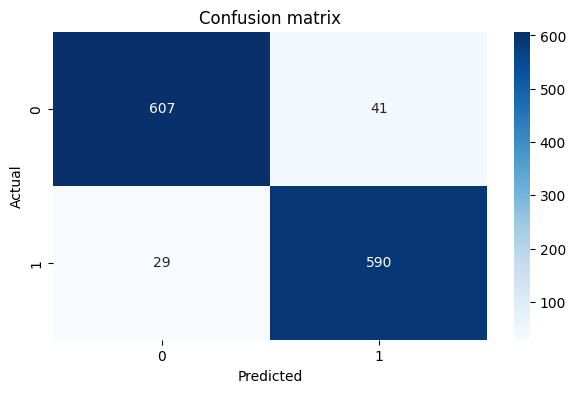

Classification report: 
               precision    recall  f1-score   support

           0       0.95      0.94      0.95       648
           1       0.94      0.95      0.94       619

    accuracy                           0.94      1267
   macro avg       0.94      0.94      0.94      1267
weighted avg       0.94      0.94      0.94      1267



In [47]:
visualize_results(y_test,alexnet_pred)

## Save Model

In [ ]:
alexnet_model.save("alexNet_model.h5")